## Устанавливаем библиотеки

In [1]:
%pip install catboost
%pip install lightgbm
%pip install xgboost
%pip install scikit-learn

import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from random import choice
from datetime import timedelta

import numpy as np
import pandas as pd
import xgboost as xgb
from catboost import CatBoostClassifier
from lightgbm import Dataset, train, early_stopping
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.ndimage import uniform_filter, maximum_filter, minimum_filter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Функции для генерации фичей и предобработки данных

In [2]:
def calculate_mean(image_channel, radius):
    """
    Вычисляет среднее значение для каждого пикселя в пределах кругового радиуса.
    
    Параметры:
    image_channel: np.array - канал изображения (R, G или B).
    radius: int - радиус области для усреднения.
    
    Возвращает:
    np.array - массив средних значений для каждого пикселя.
    """
    height, width = image_channel.shape
    mean_channel = np.zeros_like(image_channel, dtype=float)

    for y in tqdm(range(height)):
        for x in range(width):
            # Получаем индексы пикселей внутри круга с центром в (x, y)
            rr, cc = disk((y, x), radius, shape=image_channel.shape)
            
            # Вычисляем среднее значение в пределах круга
            mean_channel[y, x] = image_channel[rr, cc].mean()

    return mean_channel


def read_ik(image_path):
    # Считывание маски
    ik = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    return ik


def read_mask(image_path):
    # Считывание маски
    mask = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Объявление маски как целевой переменной
    mask = pd.Series(mask.flatten() // 255, name='target')

    return mask


def process_image(image_path, ik_path=None):
    file = image_path.split('/')[-1]
    if ik_path is None:
        ik_path = f"data/ik/{file}"

    # metadata = df_metadata.loc[file]
    weather = df_weather.loc[file]
    weather = weather.iloc[weather.time.argmax()].drop("time") # ! Обработка

    # Считывание изображения
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Преобразование изображения в RGB
    ik = read_ik(ik_path)

    # Преобразование данных изображения в DataFrame
    height, width, _ = image_rgb.shape
    data = {
        # 'x': np.repeat(np.arange(width), height),  # Координата x пикселя
        # 'y': np.tile(np.arange(height), width),    # Координата y пикселя
        'R': image_rgb[:, :, 0].flatten(),         # Значение R канала
        'G': image_rgb[:, :, 1].flatten(),         # Значение G канала
        'B': image_rgb[:, :, 2].flatten(),         # Значение B канала
        'IK': ik.flatten(),
    }

    df = pd.DataFrame(data)
    for index in weather.index:
        df[index] = weather[index]

    radiuses = np.arange(2, 10) ** 2
    data = [('R', image_rgb[:, :, 0]), ('G', image_rgb[:, :, 1]), ('B', image_rgb[:, :, 2]), ('IK', ik)]

    # Добавление минимальных значений R, G, B в радиусах ... пикселей
    for radius in radiuses:
        for color, channel in data:
            df[f'{color}_min_{radius}'] = minimum_filter(channel, size=2*radius+1, mode='reflect').flatten()
        
    df = df.copy()
            

    # Добавление максимальных значений R, G, B в радиусах ... пикселей
    for radius in radiuses:
        for color, channel in data:
            df[f'{color}_max_{radius}'] = maximum_filter(channel, size=2*radius+1, mode='reflect').flatten()
    df = df.copy()


    # Добавление усреднённых значений R, G, B в радиусах ... пикселей
    for radius in radiuses:
        for color, channel in data:
            df[f'{color}_mean_{radius}'] = uniform_filter(channel, size=2*radius+1, mode='reflect').flatten()

    return df.copy()


def preprocessing(image_names):
    # Преобразуем в список, если не является списком или кортежем
    if not isinstance(image_names, (list, tuple)):
        image_names = [image_names]
    
    # Используем генератор вместо списка для оптимизации памяти
    X_raw = pd.concat((process_image(f'{paths[0]}/{image_name}') for image_name in image_names), ignore_index=True)
    y_raw = pd.concat((read_mask(f'{paths[1]}/{image_name}') for image_name in image_names), ignore_index=True)

    # Объединение X_raw и y_raw с сохранением памяти
    df = pd.concat([X_raw, y_raw], axis=1)
    
    # Пропускаем группировку и выборку, если она не обязательна
    if 'target' in df.columns:
        min_samples = df['target'].value_counts().min()
        df = df.groupby('target').sample(min_samples).reset_index(drop=True)

    # Разделение на признаки и целевую переменную
    X, y = df.drop(columns=['target']), df['target']
    
    return X, y


def metrics(y_true, y_pred, count_round=3):
    return pd.Series(np.round([accuracy_score(y_true, y_pred), 
                               precision_score(y_true, y_pred, average='macro'), 
                               recall_score(y_true, y_pred, average='macro'), 
                               f1_score(y_true, y_pred, average='macro'), 
                               matthews_corrcoef(y_true, y_pred)], count_round), 
                            index=['accuracy', 'precision', 'recall', 'f1_score', 'matthews_corrcoef'])

### Загружаем данные

In [3]:
# df_metadata = pd.read_csv("data/metadata.csv", index_col=0)
df_weather = pd.read_csv("data/weather.csv").set_index('file')

paths = ('data/image', 'data/mask')
images = os.listdir(paths[0])
train_images, test_images = train_test_split(images, test_size=0.2)

# X_train, y_train = preprocessing(train_images)
# X_test, y_test = preprocessing(test_images)

X, y = preprocessing(train_images)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

# Обучаем бустинги

### CatBoost

In [4]:
cb_clf = CatBoostClassifier(iterations=1000, max_depth=8, eval_metric='MCC', early_stopping_rounds=20, random_state=42, use_best_model=True, verbose=100)

cb_clf.fit(X_train, y_train, eval_set=(X_test, y_test))

Learning rate set to 0.12341
0:	learn: 0.6887043	test: 0.6915476	best: 0.6915476 (0)	total: 76.6ms	remaining: 1m 16s
100:	learn: 0.8003694	test: 0.7957807	best: 0.7957807 (100)	total: 2.55s	remaining: 22.7s
200:	learn: 0.8257910	test: 0.8157278	best: 0.8157278 (200)	total: 5s	remaining: 19.9s
300:	learn: 0.8397550	test: 0.8235399	best: 0.8235399 (300)	total: 7.67s	remaining: 17.8s
400:	learn: 0.8499349	test: 0.8282074	best: 0.8282074 (400)	total: 10.4s	remaining: 15.5s
500:	learn: 0.8578859	test: 0.8316100	best: 0.8318085 (495)	total: 13.1s	remaining: 13s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8328066197
bestIteration = 519

Shrink model to first 520 iterations.


### LightGBM

In [5]:
train_data = Dataset(
    X_train,
    y_train,
    free_raw_data=False,
)

val_data = Dataset(
    X_test,
    y_test,
    free_raw_data=False,
)

params = {
    "objective": "multiclass",
    "num_class": 2,
}

lgbm_clf = train(
    params,
    train_set=train_data, 
    valid_sets=(val_data),
    num_boost_round=500,
    callbacks=[early_stopping(stopping_rounds=5)]
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12451
[LightGBM] [Info] Number of data points in the train set: 245728, number of used features: 107
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] Start training from score -0.693147
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's multi_logloss: 0.220937


### XGBoost

In [6]:
xgb_clf = xgb.XGBClassifier(
                        objective="binary:logistic",
                        tree_method="hist",
                        enable_categorical=False,
                        max_depth=8,
                        num_boosting_rounds=500,
                        eval_metric = matthews_corrcoef
                        )

xgb_clf.fit(X_train, y_train)

/home/simon/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [05:47:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "num_boosting_rounds" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False,
              eval_metric=<function matthews_corrcoef at 0x78daf1ad6980>,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_boosting_rounds=500, num_parallel_tree=None, ...)

# Смотрим метрики и блендим

In [7]:
print('CatBoost')
cb_y_pred = cb_clf.predict(X_test)
metrics(y_test, cb_y_pred)

CatBoost


accuracy             0.915
precision            0.917
recall               0.915
f1_score             0.915
matthews_corrcoef    0.833
dtype: float64

In [8]:
print('LightGBM')
lgbm_y_pred = np.argmax(lgbm_clf.predict(X_test), axis=1)
metrics(y_test, lgbm_y_pred)

LightGBM


accuracy             0.915
precision            0.917
recall               0.915
f1_score             0.915
matthews_corrcoef    0.832
dtype: float64

In [9]:
print('XGBoost')
xgb_y_pred = xgb_clf.predict(X_test)
metrics(y_test, xgb_y_pred)

XGBoost


accuracy             0.917
precision            0.919
recall               0.917
f1_score             0.917
matthews_corrcoef    0.836
dtype: float64

In [10]:
print('Hard Voting')
metrics(y_test, (cb_y_pred + lgbm_y_pred + xgb_y_pred) // 2)

Hard Voting


accuracy             0.917
precision            0.919
recall               0.917
f1_score             0.917
matthews_corrcoef    0.836
dtype: float64

In [11]:
print('Soft Voting')

cb_pred = cb_clf.predict_proba(X_test)
lgbm_pred = lgbm_clf.predict(X_test)
xgb_pred = xgb_clf.predict_proba(X_test)

soft_voting = []
for i in range(len(cb_pred)):
    if cb_pred[i][0] * 0.4 + lgbm_pred[i][0] * 0.3 + xgb_pred[i][0] * 0.3 >= 0.5:
        soft_voting.append(0)
    else:
        soft_voting.append(1)

metrics(y_test, soft_voting)

Soft Voting


accuracy             0.917
precision            0.919
recall               0.917
f1_score             0.917
matthews_corrcoef    0.837
dtype: float64

# Визуализируем

### Вспомогательные функции

In [12]:
def cb_predict(image_path, save_path=None):
    X = process_image(image_path)
    y_pred = cb_clf.predict(X).reshape(cv2.imread(image_path).shape[:2])
    
    if save_path is None:
        return y_pred
    
    # Сохранение изображения
    cv2.imwrite(save_path, y_pred)


def lgbm_predict(image_path, save_path=None):
    X = process_image(image_path)
    y_pred = np.argmax(lgbm_clf.predict(X), axis=1).reshape(cv2.imread(image_path).shape[:2])
    
    if save_path is None:
        return y_pred
    
    # Сохранение изображения
    cv2.imwrite(save_path, y_pred)


def xgb_predict(image_path, save_path=None):
    X = process_image(image_path)
    y_pred = xgb_clf.predict(X).reshape(cv2.imread(image_path).shape[:2])
    
    if save_path is None:
        return y_pred
    
    # Сохранение изображения
    cv2.imwrite(save_path, y_pred)


def soft_voting_predict(image_path, save_path=None):
    X = process_image(image_path)
    cb_pred = cb_clf.predict_proba(X)
    lgbm_pred = lgbm_clf.predict(X)
    xgb_pred = xgb_clf.predict_proba(X)
    
    res = []
    for i in range(len(cb_pred)):
        if cb_pred[i][0] * 0.4 + lgbm_pred[i][0] * 0.3 + xgb_pred[i][0] * 0.3 >= 0.5:
            res.append(0)
        else:
            res.append(1)
    res = np.array(res).reshape(cv2.imread(image_path).shape[:2])
    
    if save_path is None:
        return res
    
    # Сохранение изображения
    cv2.imwrite(save_path, res)

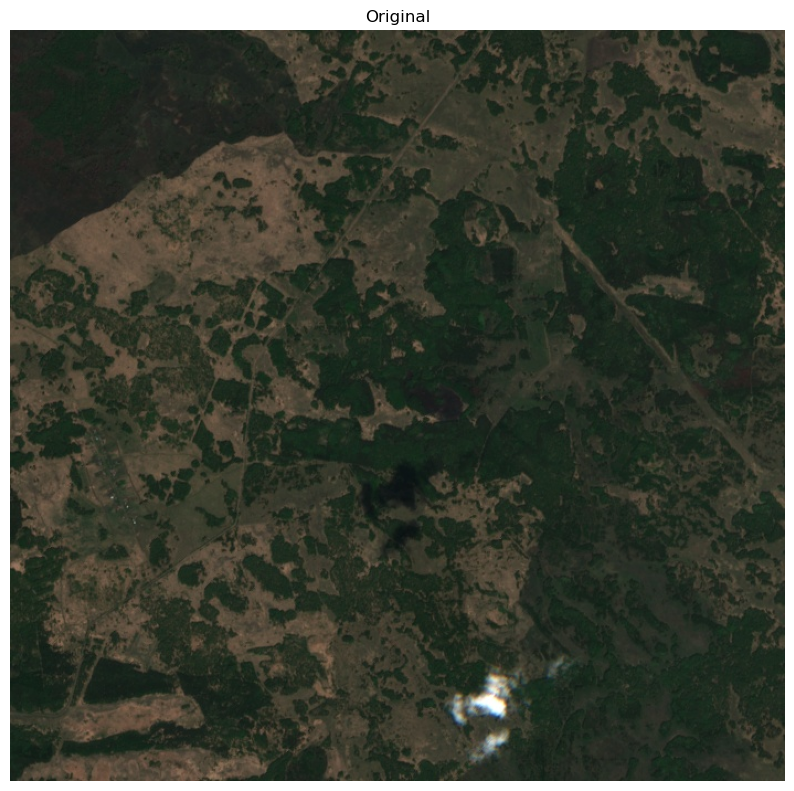

In [13]:
sample = choice(test_images)

# Загрузите изображение
image = Image.open(f'{paths[0]}/{sample}')

# Настройте размер отображения
plt.figure(figsize=(10, 10))  # Установите нужный размер (ширина, высота) в дюймах

# Отобразите изображение
plt.imshow(image, cmap='gray')
plt.title("Original")
plt.axis('off')  # Скрыть оси
plt.show()

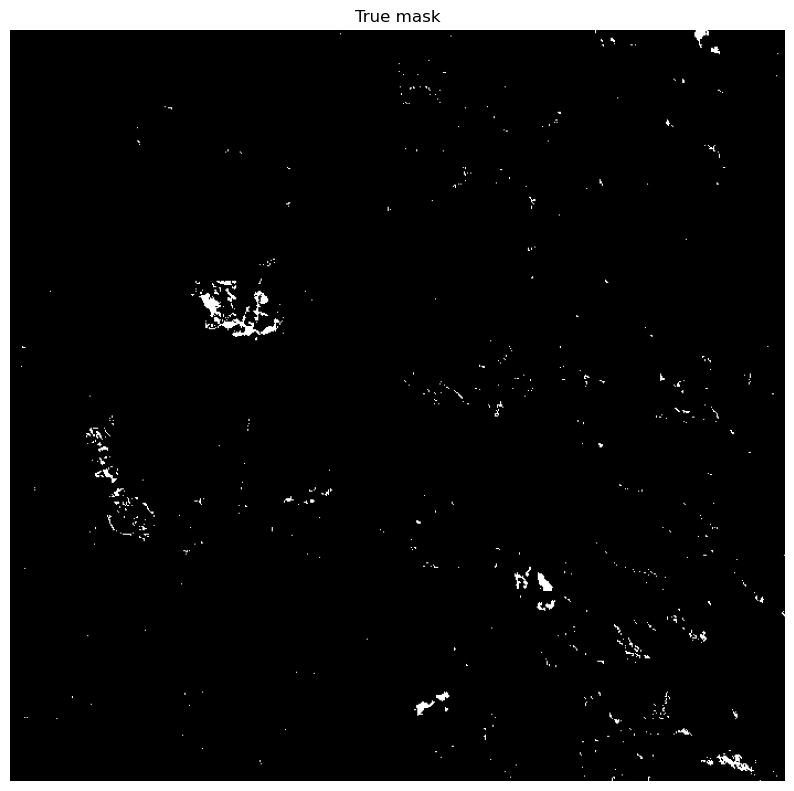

In [14]:
# Загрузите изображение
image = Image.open(f'{paths[1]}/{sample}')

# Настройте размер отображения
plt.figure(figsize=(10, 10))  # Установите нужный размер (ширина, высота) в дюймах

# Отобразите изображение
plt.imshow(image, cmap='gray')
plt.title("True mask")
plt.axis('off')  # Скрыть оси
plt.show()

### Soft Voting

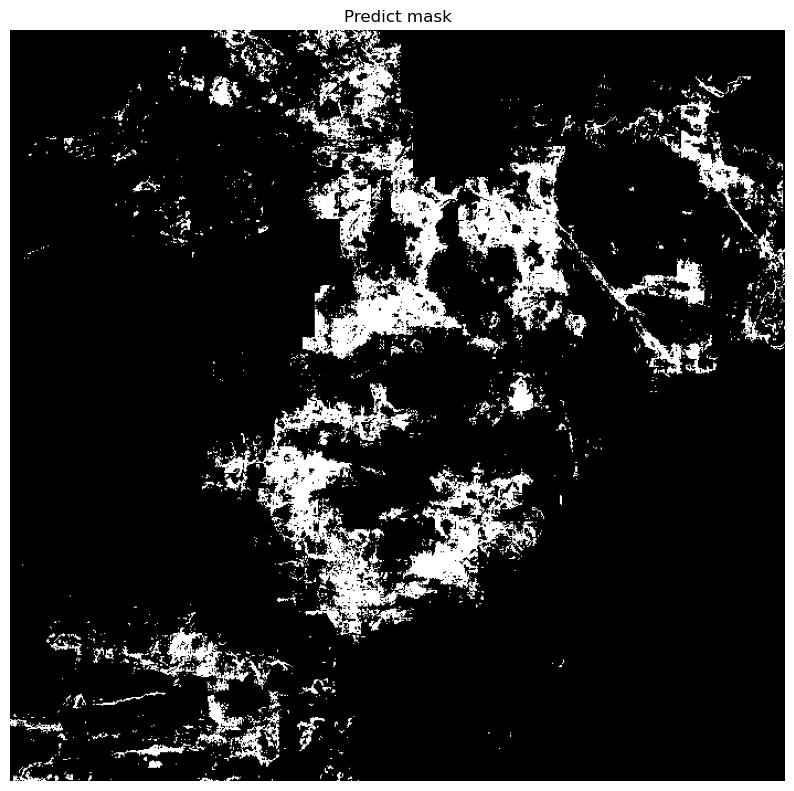

In [15]:
image = soft_voting_predict(f'{paths[0]}/{sample}')

# Визуализация с помощью imshow
plt.figure(figsize=(10, 10))
plt.title("Predict mask")
plt.imshow(image, cmap='gray')
plt.axis('off')  # Скрыть оси
plt.show()

### CatBoost

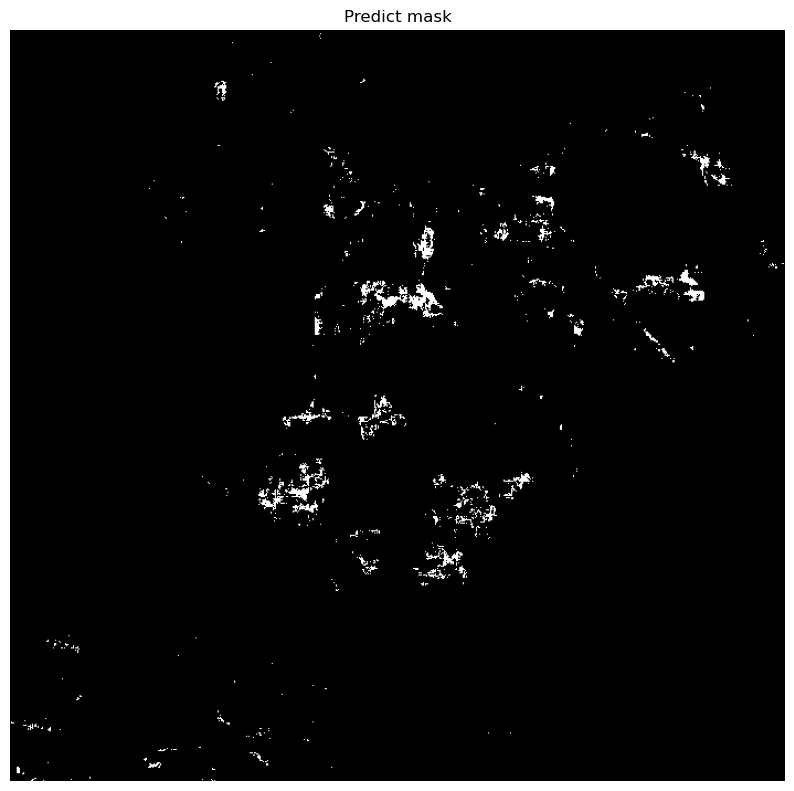

In [16]:
image = cb_predict(f'{paths[0]}/{sample}')

# Визуализация с помощью imshow
plt.figure(figsize=(10, 10))
plt.title("Predict mask")
plt.imshow(image, cmap='gray')
plt.axis('off')  # Скрыть оси
plt.show()

### LightGBM

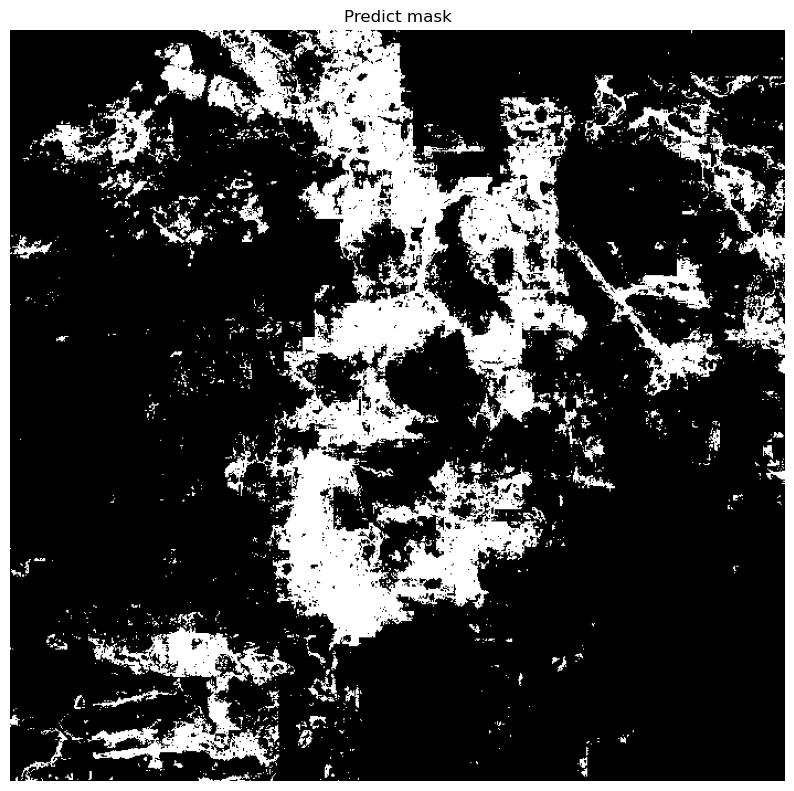

In [17]:
image = lgbm_predict(f'{paths[0]}/{sample}')

# Визуализация с помощью imshow
plt.figure(figsize=(10, 10))
plt.title("Predict mask")
plt.imshow(image, cmap='gray')
plt.axis('off')  # Скрыть оси
plt.show()

### XGBoost

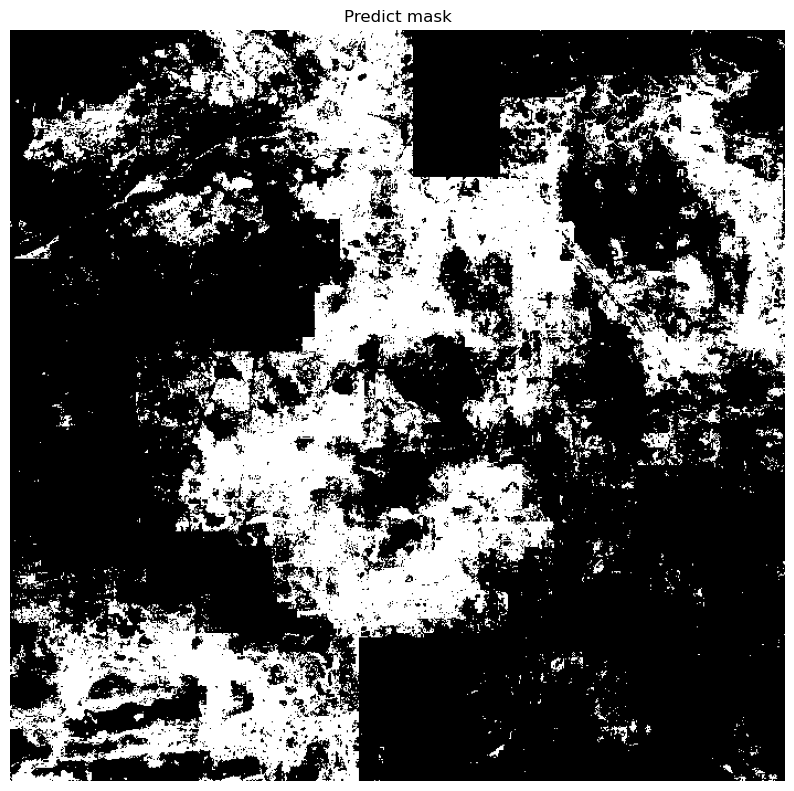

In [18]:
image = xgb_predict(f'{paths[0]}/{sample}')

# Визуализация с помощью imshow
plt.figure(figsize=(10, 10))
plt.title("Predict mask")
plt.imshow(image, cmap='gray')
plt.axis('off')  # Скрыть оси
plt.show()

In [20]:
# сохраням веса модели, мы выбрали CatBoost
X_train = pd.concat([X_train, X_test])
y_train = pd.concat([y_train, y_test])
cb_clf.fit(X_train, y_train, eval_set=(X_test, y_test))
cb_clf.save_model("CatBoostNet.cbm")

Learning rate set to 0.140007
0:	learn: 0.6843618	test: 0.6860985	best: 0.6860985 (0)	total: 46.7ms	remaining: 46.7s
100:	learn: 0.8042117	test: 0.8073769	best: 0.8073769 (100)	total: 3.71s	remaining: 33s
200:	learn: 0.8298479	test: 0.8342903	best: 0.8342903 (200)	total: 7.26s	remaining: 28.9s
300:	learn: 0.8428807	test: 0.8490931	best: 0.8490931 (300)	total: 10.8s	remaining: 25.2s
400:	learn: 0.8526936	test: 0.8609617	best: 0.8609617 (400)	total: 14.4s	remaining: 21.5s
500:	learn: 0.8602393	test: 0.8698411	best: 0.8700052 (496)	total: 18s	remaining: 17.9s
600:	learn: 0.8661160	test: 0.8771223	best: 0.8771223 (600)	total: 21.6s	remaining: 14.3s
700:	learn: 0.8716993	test: 0.8839802	best: 0.8839802 (700)	total: 25.3s	remaining: 10.8s
800:	learn: 0.8772338	test: 0.8909503	best: 0.8909503 (800)	total: 29.2s	remaining: 7.24s
900:	learn: 0.8812991	test: 0.8957422	best: 0.8957422 (900)	total: 32.8s	remaining: 3.61s
999:	learn: 0.8851078	test: 0.9000493	best: 0.9000493 (999)	total: 36.4s	rema